# Background creation and parameter exploration

## Explored
- Creation of a flat background/seq
- Influencial parameters in creating a flat background/seq

## Goal
- Obtain a standard set of parameters for creating a flat seq.

In [1]:
# Importing libraries

from basenji import dataset, seqnn, dna_io,stream
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import seaborn as sns
import akita_utils 
import tensorflow as tf
import pysam
import h5py

# Getting genomic data

In [2]:
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile(genome_fasta)

# Loading akita model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
print(tf.__version__)

head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-07-21 20:46:12.602753: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


built
restored


(512, 130305, (130305,))

# Fetching chromosome data to explore background creation

In [4]:
chromsizes = bioframe.read_chromsizes('/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed')
dframe = pd.DataFrame(chromsizes)
dframe['end'] = dframe['length']+ 1310720
dframe = dframe.reset_index()
dframe.rename(columns = {'index' : 'chrom', 'length':'start'}, inplace = True)
df = bioframe.frac_gc(dframe, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)

df

,chrom,start,end,GC
0,chr1,40415232,41725952,0.407777
1,chr1,42708992,44019712,0.424985
2,chr1,42053632,43364352,0.424847
3,chr1,41725952,43036672,0.411407
4,chr1,43036672,44347392,0.417725
...,...,...,...,...
6033,chrX,99241984,100552704,0.424162
6034,chrX,120532992,121843712,0.367963
6035,chrX,139360256,140670976,0.407839
6036,chrX,128737280,130048000,0.370827


In [5]:
# visualizing the gc content distribution

# plt.hist( df['GC'].values, 100);
# np.percentile(df['GC'].dropna().values, np.linspace(1,99,5))

# Generating a sample for down stream analysis

In [6]:
super_set = []
error = 0.0001

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,6)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            super_set += [i]
            break

super_set = list(set(super_set)); print(f'Whole distribution: {super_set}')
sample_set = super_set; print(f'Sampled datapoints: {sample_set}')

Whole distribution: [1216, 1286, 140, 111, 597, 600]
Sampled datapoints: [1216, 1286, 140, 111, 597, 600]


# Making predictions for the sampled data

In [7]:
predictions=[]

for ind in set(sample_set):
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    genome_open = pysam.Fastafile(genome_fasta)
    seq = genome_open.fetch(chrom, start, end).upper()
    seq_1hot = dna_io.dna_1hot(seq)
    predictions.append(seq_1hot)
    
predictions = np.array(predictions)
predictions = seqnn_model.predict(predictions, batch_size=6)

2022-07-21 20:47:21.046885: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-21 20:47:21.047239: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2595255000 Hz


# Creating flat backroung seqs from sampled data

In [8]:
# Paramaters for all analysis downstream
max_iters = 10
batch_size = 5
shuffle_k = 8 
ctcf_thresh = 8 
scores_thresh = 5500 
scores_pixelwise_thresh = .05
new_dataframe = df.iloc[[ind for ind in set(sample_set)]]
# ---------------------------------------------------------------

# For comparison further down
shuffle_set = [2,4,8] # shuffling basepairs to sample for comparison
scores_thresh_set = [5000,5500,6000] # ctcf thresholds to sample for comparison

In [9]:
flat_seqs = akita_utils.create_flat_seqs(seqnn_model=seqnn_model, 
                                        genome_fasta=genome_fasta, 
                                        seq_length=seq_length, 
                                        dataframe=new_dataframe, 
                                        max_iters = max_iters, 
                                        batch_size = batch_size, 
                                        shuffle_k = shuffle_k, 
                                        ctcf_thresh = ctcf_thresh, 
                                        scores_thresh = scores_thresh, 
                                        scores_pixelwise_thresh = scores_pixelwise_thresh )

ind 0 , iter  0 , for chr3 71278592 72589312
success: best seq, thresh 5370.0  pixelwise 0.0393 time 5.198777437210083
max iters exceeded, final time 5.198777437210083
ind 1 , iter  0 , for chr3 8570880 9881600
trying: best seq, thresh 9330.0  pixelwise 0.0566
ind 1 , iter  1 , for chr3 8570880 9881600
trying: best seq, thresh 8344.0  pixelwise 0.053
ind 1 , iter  2 , for chr3 8570880 9881600
trying: best seq, thresh 9500.0  pixelwise 0.06116
ind 1 , iter  3 , for chr3 8570880 9881600
trying: best seq, thresh 9070.0  pixelwise 0.06537
ind 1 , iter  4 , for chr3 8570880 9881600
trying: best seq, thresh 9390.0  pixelwise 0.0599
ind 1 , iter  5 , for chr3 8570880 9881600
trying: best seq, thresh 8060.0  pixelwise 0.0559
ind 1 , iter  6 , for chr3 8570880 9881600
trying: best seq, thresh 10584.0  pixelwise 0.0666
ind 1 , iter  7 , for chr3 8570880 9881600
trying: best seq, thresh 9090.0  pixelwise 0.05618
ind 1 , iter  8 , for chr3 8570880 9881600
trying: best seq, thresh 9300.0  pixelwise

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


trying: best seq, thresh 13544.0  pixelwise 0.1355
ind 5 , iter  1 , for chr2 27127808 28438528
trying: best seq, thresh 12350.0  pixelwise 0.1512
ind 5 , iter  2 , for chr2 27127808 28438528
trying: best seq, thresh 15110.0  pixelwise 0.168
ind 5 , iter  3 , for chr2 27127808 28438528
trying: best seq, thresh 16030.0  pixelwise 0.1283
ind 5 , iter  4 , for chr2 27127808 28438528
trying: best seq, thresh 14040.0  pixelwise 0.1453
ind 5 , iter  5 , for chr2 27127808 28438528
trying: best seq, thresh 12640.0  pixelwise 0.1526
ind 5 , iter  6 , for chr2 27127808 28438528
trying: best seq, thresh 14640.0  pixelwise 0.1688
ind 5 , iter  7 , for chr2 27127808 28438528
trying: best seq, thresh 15944.0  pixelwise 0.1638
ind 5 , iter  8 , for chr2 27127808 28438528
trying: best seq, thresh 11950.0  pixelwise 0.1869
ind 5 , iter  9 , for chr2 27127808 28438528
trying: best seq, thresh 12060.0  pixelwise 0.1678
max iters exceeded, final time 45.410505056381226


# Visualizing the created flat seqs' contact maps

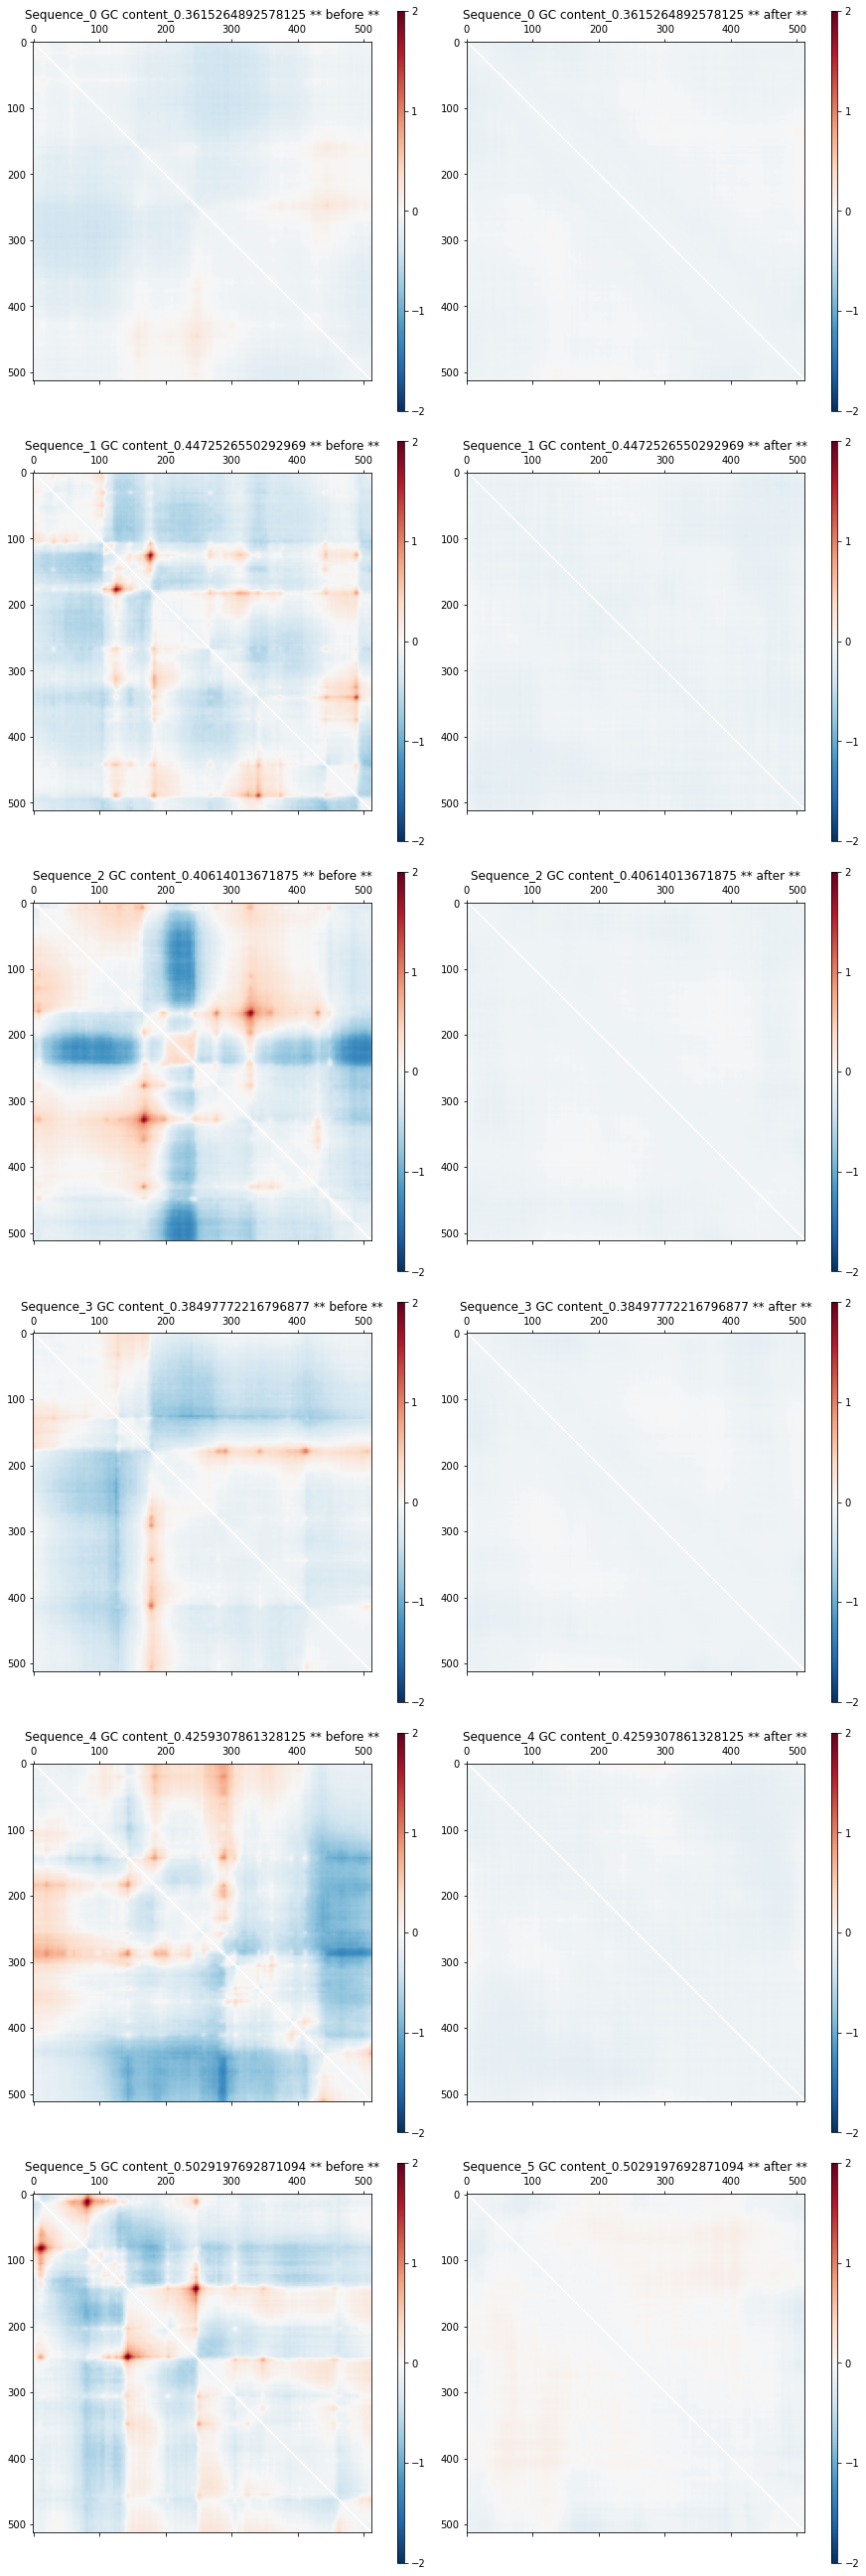

In [10]:
fig = plt.figure(figsize=(6* 2 , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=2, nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
target_ind = 0
vmin=-2; vmax=2

for i in range(len(sample_set)):
    
    flat_pred = flat_seqs[i][1]
    gc        = flat_seqs[i][-1]
    back_pred = predictions[i]

    mat = akita_utils.from_upper_triu(back_pred[:,target_ind], target_map_size,hic_diags)
    ax1 = fig.add_subplot(spec[i,0])
    im = ax1.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)# 
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
    plt.title(f'Sequence_{i} GC content_{gc} ** before **')       
           
    mat = akita_utils.from_upper_triu(flat_pred[:,target_ind], target_map_size,hic_diags)
    ax2 = fig.add_subplot(spec[i,1])
    im = ax2.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])       
    plt.title(f'Sequence_{i} GC content_{gc} ** after **')       
        
plt.show()

# General distribution of scores

In [ ]:
scores_before = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for k in shuffle_set:
        print(gc,k)
        scores_before[gc,k] = akita_utils.custom_calculate_scores(  seqnn_model=seqnn_model, 
                                                                    genome_fasta=genome_fasta, 
                                                                    seq_length=seq_length, 
                                                                    dataframe=new_dataframe, 
                                                                    max_iters = max_iters, 
                                                                    batch_size = batch_size, 
                                                                    shuffle_k = k, 
                                                                    ctcf_thresh = ctcf_thresh, 
                                                                    scores_thresh = scores_thresh,
                                                                    scores_pixelwise_thresh = scores_pixelwise_thresh)
        
# scores_before

1216 2
ind 0 , iter  0 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  1 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  2 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  3 ,k  2 , for chr3 71278592 72589312


# Visualing the scores' distribution for the created flat seqs

In [ ]:
fig = plt.figure(figsize=(6* len(shuffle_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=len(shuffle_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for k in shuffle_set:
        ax1 = fig.add_subplot(spec[sample_set.index(ind),shuffle_set.index(k)])
        
        temp_scores_before = []
        for i in scores_before[ind,k]:
            temp_scores_before =+ i
        
        kde_df_before = pd.DataFrame(temp_scores_before, columns=["score"])
        sns.kdeplot(data=kde_df_before, x="score", bw_adjust=.2, fill=True)
        
        plt.title(f'GC_{gc} k_{k} score distributions')
        plt.legend()

plt.show()
plt.close()

# Some observations

With a threshold of 6000;

As the gc content lowers, scores below threshold are obtained in k=8, some low scores can be obtained in the k=4,2. For really low gc content, more low scores can be obtained for k=4.

This implies k=8 is the best option over a wide range of gc content distribution and thus will be used futher on.

In [ ]:
shuffle_set = [8]

# Now we focus on how to maskout some CTCF motifs to lower the structure in our maps


In [ ]:
# max_iters=50
# batch_size=6

# scores_storage_random_masking = mutation_search(    seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=max_iters,
#                                                     batch_size=batch_size,
#                                                     masking=0)

# print('**********************************')

# scores_storage_motif_masking = mutation_search(     seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=max_iters,
#                                                     batch_size=batch_size,
#                                                     masking=1)

# print('**********************************')

# scores_storage_all_random = mutation_search(        seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=max_iters,
#                                                     batch_size=batch_size)

In [ ]:
# Y_1 = []
# Y_2 = []
# Y_3 = []

# for i in scores_storage_random_masking:
#     for j in scores_storage_random_masking[i]:
#         Y_1 += j.tolist()

# for i in scores_storage_motif_masking:
#     for j in scores_storage_motif_masking[i]:
#         Y_2 += j.tolist()        

# for i in scores_storage_all_random:
#     for j in scores_storage_all_random[i]:
#         Y_3 += j.tolist()

# kde_1 = pd.DataFrame(Y_1, columns=["score"])
# kde_2 = pd.DataFrame(Y_2, columns=["score"])
# kde_3 = pd.DataFrame(Y_3, columns=["score"])
# sns.kdeplot(data=kde_1, x="score", bw_adjust=.2, label='random masking', fill=True)  
# sns.kdeplot(data=kde_2, x="score", bw_adjust=.2, label='motif masking', fill=True)    
# sns.kdeplot(data=kde_3, x="score", bw_adjust=.2, label='all random', fill=True)    
# plt.legend()
# plt.show()

# Some observations

For high gc content, there is no success for k=2,4.  As the gc content lowers, some success can be obtained in the k=4. For really low gc content, more success can be obtained for k=4.

This implies k=8 is the best option over a wide range of gc content distribution.

# Now we try different thresholds to maskout the CTCF motifs
### (strength of motif)

In [ ]:
scores_thresh_after = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for score in scores_thresh_set:
        print(gc,score)
        scores_thresh_after[gc,score] = akita_utils.custom_calculate_scores(seqnn_model = seqnn_model, 
                                                            genome_fasta = genome_fasta, 
                                                            seq_length = seq_length, 
                                                            dataframe = new_dataframe, 
                                                            max_iters = max_iters, 
                                                            batch_size = batch_size, 
                                                            shuffle_k = 8, 
                                                            ctcf_thresh = ctcf_thresh, 
                                                            scores_thresh = score, 
                                                            scores_pixelwise_thresh = scores_pixelwise_thresh,
                                                            success_scores = 1,                
                                                            masking = True)

# Visualing the scores' distribution for the created seqs

In [ ]:
fig1 = plt.figure(figsize=(6* len(scores_thresh_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec1 = fig1.add_gridspec(ncols=len(scores_thresh_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for score in scores_thresh_set:
        ax1 = fig1.add_subplot(spec1[sample_set.index(ind),scores_thresh_set.index(score)])
        
        temp_scores_thresh_after = []
        for i in scores_thresh_after[ind,score]:
            temp_scores_thresh_after =+ i
        
        kde_df_after = pd.DataFrame(temp_scores_thresh_after, columns=["score"])
        sns.kdeplot(data=kde_df_after, x="score", bw_adjust=.1, fill=True)
        ax1.legend()        
        plt.title(f'GC_{gc} scores_thresh_{score}')

plt.show()
plt.close()

# Some observations


For high gc content and low threshold, there is no success.  As the gc content lowers, some success can be obtained in higher thresholds. For really low gc content, more success can be obtained for lower thresholds.

This implies that to create a background seq, you need a reasonably low gc content and threshold.

# Now we focus on effect of masking to basepairs shuffled.  

In [ ]:
scores_shuffle_after = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for k in shuffle_set:
        print(gc,k)
        scores_shuffle_after[gc,k] = akita_utils.custom_calculate_scores(seqnn_model = seqnn_model, 
                                                                    genome_fasta = genome_fasta, 
                                                                    seq_length = seq_length, 
                                                                    dataframe = new_dataframe, 
                                                                    max_iters = max_iters, 
                                                                    batch_size = batch_size, 
                                                                    shuffle_k = k, 
                                                                    ctcf_thresh = ctcf_thresh, 
                                                                    scores_thresh = scores_thresh, 
                                                                    scores_pixelwise_thresh = scores_pixelwise_thresh,
                                                                    success_scores = 1,
                                                                    masking = False)

# Visualizing the resultant score distributions.

In [ ]:
fig = plt.figure(figsize=(6* len(shuffle_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=len(shuffle_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for k in shuffle_set:
        ax1 = fig.add_subplot(spec[sample_set.index(ind),shuffle_set.index(k)])
        # plt.hist(scores_after[gc,k],5)
        
        temp_scores_shuffle_after = []
        for i in scores_shuffle_after[ind,k]:
            temp_scores_shuffle_after =+ i
            
        temp_scores_before = []
        for i in scores_before[ind,k]:
            temp_scores_before =+ i
        
        kde_df_after = pd.DataFrame(temp_scores_shuffle_after, columns=["score"])
        kde_df_before = pd.DataFrame(temp_scores_before, columns=["score"])
        sns.kdeplot(data=kde_df_after, x="score", bw_adjust=.1, label='after',fill=True)
        sns.kdeplot(data=kde_df_before, x="score", bw_adjust=.1, label='before',fill=True)#
        ax1.legend()
        plt.title(f'GC_{gc} k_{k} before and after masking')
plt.show()
plt.close()

# Final observations

The first parameter for focus when desighing a background seq is the gc content of the initial seq.
Seq with lower gc are preffeerd

The second parameter is the shuffling basepairs, k=8 is prefferd

Third is threshold, i have chosen 6000